In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import cv2
import re
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa

from PIL import Image
import IPython.display as ipd

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm
from utils import io, train
from utils import feature_engineering as fe

In [10]:

videos_folder = "../data_full/videos"
gt_folder = "../data_full/gt_annotations"
temp_folder = "../data_full/tmp/"

In [11]:
episode_names, video_paths, gt_df = io.get_init_vars(gt_folder, videos_folder)

In [12]:
episode_names

['Muppets-02-01-01', 'Muppets-02-04-04', 'Muppets-03-04-03']

# Preparation

Idea: use straight lines for the detection of Balcony Gentlemens, since Balcony has a very characteristical straight lines. Can we use Hough Transform in Sim1? 

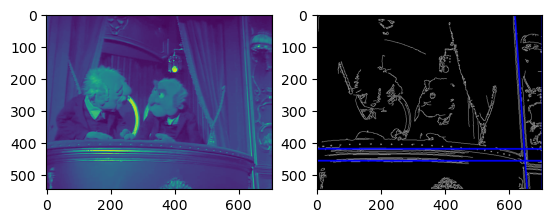

In [5]:
import math
import cv2 as cv
img_path = '../data/frames/Muppets-03-04-03/frame_09404.jpg' 
src = cv.imread(img_path, cv.IMREAD_GRAYSCALE)    
dst = cv.Canny(src, 50, 200, None, 3)
    
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

lines = cv.HoughLinesWithAccumulator(dst, 1, np.pi / 180, 200, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv.line(cdst, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
        if i == 3:
            break

plt.subplot(1,2,1)
plt.imshow(src)
plt.subplot(1,2,2)
plt.imshow(cdst)

In [6]:
# line_feat_dict = {}

# for ep in episode_names:
#     cap = io.load_video(video_paths[ep])
#     frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     line_num_list = []  
#     max_votes_list = []
    
#     for i in range(frame_count):
#         _, frame = cap.read()

#         dst = cv2.Canny(frame, 50, 200, None, 3)
#         cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
#         cdstP = np.copy(cdst)
#         lines = cv2.HoughLinesWithAccumulator(dst, 0.5, np.pi / 180, 200, None, 0, 0)
        
#         line_feat = len(lines) if lines is not None else 0
#         max_votes = lines[0][0][2] if lines is not None else 0

#         line_num_list.append(line_feat)
#         max_votes_list.append(max_votes)

#     line_feat_dict[ep] = {}
#     line_feat_dict[ep]['num_lines'] =  np.array(line_num_list)[1:]
#     line_feat_dict[ep]['max_votes'] =  np.array(max_votes_list)[1:]

#     del line_num_list
#     del max_votes_list
#     cap.release()

Compute blobs:

In [7]:
radius_col = 2
n_max = 3
debug = False
white_params = {
    'mu_v': 200, 
    'sigma_v': 40, 
    'mu_h': 30, 
    'sigma_h': 30
}

radien_feat_dict = {}

for ep in episode_names:
    cap = io.load_video(video_paths[ep])
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    green_radien_list = []  
    white_radien_list = []
    
    for i in tqdm(range(frame_count)):
        _, image = cap.read()

        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_rbg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if debug:
            plt.imshow(image_rbg)

        sigma = 7
        green_yellow = np.uint8([[[255*0.85, 255, 0]]])
        hsv_green_yellow = cv2.cvtColor(green_yellow, cv2.COLOR_RGB2HSV)
        mu = hsv_green_yellow[0, 0, 0]

        blob_list = fe.detect_blob(image_hsv, sigma, mu, debug=debug)
        blob_radius = blob_list[:, radius_col]
        biggest_radien_green = blob_radius[np.argsort(blob_radius)[-n_max:]]

        keypoints = fe.detect_blob_cv(image_gray, image, image_hsv, debug=debug, **white_params)
        k_radien = np.array([k.size for k in keypoints])
        biggest_radien_eyes = k_radien[np.argsort(k_radien)[-n_max:]]

    radien_feat_dict[ep] = {}
    radien_feat_dict[ep]['num_lines'] =  np.array(green_radien_list)[1:]
    radien_feat_dict[ep]['max_votes'] =  np.array(white_radien_list)[1:]

    del green_radien_list
    del white_radien_list
    cap.release()


Loaded video with resolution 720x544
FPS = 25.0, Frame Count = 38682, Codec = FMP4


  0%|          | 0/38682 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
pickle.dump(radien_feat_dict, open("../data/features/radien_feat_dict.pkl", "wb"))

In [ ]:
img_path = '../data/frames/Muppets-03-04-03/frame_00000.jpg'
image = cv2.imread(img_path)
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_rbg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
if debug:
    plt.imshow(image_rbg)

sigma = 7
green_yellow = np.uint8([[[255*0.85, 255, 0]]])
hsv_green_yellow = cv2.cvtColor(green_yellow, cv2.COLOR_RGB2HSV)
mu = hsv_green_yellow[0, 0, 0]

# blob_list = fe.detect_blob(image_hsv, sigma, mu, debug=debug)
# blob_radius = blob_list[:, radius_col]
# biggest_radien_green = blob_radius[np.argsort(blob_radius)[-n_max:]]

# keypoints = fe.detect_blob_cv(image_gray, image, image_hsv, debug=debug, **white_params)
# k_radien = np.array([k.size for k in keypoints])
# biggest_radien_eyes = k_radien[np.argsort(k_radien)[-n_max:]]

In [ ]:
ep

'Muppets-03-04-03'

In [ ]:
# from sklearn.cluster import MiniBatchKMeans
# from scipy.cluster.vq import whiten
# n_clusters = 5
# batch_size = 2048

# hue_feat_list = {}

# for ep in ['Muppets-03-04-03']:
#     cap = io.load_video(video_paths[ep])
#     frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#     hue_list = []

#     for i in tqdm(range(frame_count)):
#         _, image = cap.read()

#         image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#         hue = image[:, :, 0].flatten()
#         hue_std = hue.std()
#         if hue_std == 0:
#             hue_list.append([[0, 0] for _ in range(n_clusters)])
#             continue
#         scaled_hue = np.expand_dims(whiten(hue), -1)

#         km = MiniBatchKMeans(n_clusters = n_clusters, batch_size=batch_size, n_init='auto').fit(scaled_hue)
#         cluster_centers = km.cluster_centers_

#         dominant_hues = []
#         for cluster_center in cluster_centers:
#             hue_scaled = cluster_center[0]
        
#             # Convert each standardized value to scaled value
#             dominant_hues.append(
#                 hue_scaled * hue_std,
#             )

#         hues = np.asarray(dominant_hues, dtype='uint8')

#         percentage = np.asarray(np.unique(km.labels_, return_counts = True)[1], dtype='float32')
#         percentage = percentage/(image.shape[0]*image.shape[1])

#         if len(percentage) < n_clusters:
#             percentage = np.append(percentage, np.zeros(n_clusters - len(percentage)))

#         dom = [[percentage[ix], hues[ix]] for ix in range(km.n_clusters)]
#         dominance = sorted(dom, key=lambda x:x[0], reverse=True)

#         hue_list.append(dominance)

#         del km

#     hue_feat_list[ep] = {}
#     hue_feat_list[ep]['hue_list'] =  np.array(hue_list)[1:]

#     del hue_list
#     cap.release()


Loaded video with resolution 704x544
FPS = 25.0, Frame Count = 38499, Codec = FMP4


100%|██████████| 38499/38499 [40:03<00:00, 16.02it/s]


In [ ]:
hue_feat_list = pickle.load(open("../data/features/hue_feat_list_full.pkl", "rb"))

Compute audio features:

In [ ]:
ep_dfs = []
for ep in episode_names:
    rec, sr = librosa.load(video_paths[ep], sr=None)

    frame_size_ms = 400
    hop_length = int(1/25 * sr)
    frame_length = int(frame_size_ms / 1000 * sr)
    
    desired_len = len(gt_df[gt_df.episode==ep])
    zcr = librosa.feature.zero_crossing_rate(y=rec, frame_length=frame_length, hop_length=hop_length)
    zcr = np.pad(zcr, pad_width=((0, 0), (0, desired_len - zcr.shape[1]))).flatten()

    rms = librosa.feature.rms(y=rec, frame_length=frame_length, hop_length=hop_length)
    rms = np.pad(rms, pad_width=((0, 0), (0, desired_len - rms.shape[1]))).flatten()

    mfcc = librosa.feature.mfcc(y=rec, sr=sr, n_fft=frame_length, hop_length=hop_length)
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, desired_len - mfcc.shape[1])))

    ep_df = pd.DataFrame()

    ep_df['zcr'] = zcr
    ep_df['rms'] = rms
    
    for i in range(mfcc.shape[0]):
        ep_df[f'mfcc_{i}'] = mfcc[i]
    
    ep_df['episode'] = ep
    ep_dfs.append(ep_df)

feat_df = pd.concat(ep_dfs)

C:\Users\Alina\AppData\Local\Temp\ipykernel_6056\174046906.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  rec, sr = librosa.load(video_paths[ep], sr=None)
c:\Users\Alina\anaconda3\envs\SimilarityModeling\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\Alina\AppData\Local\Temp\ipykernel_6056\174046906.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  rec, sr = librosa.load(video_paths[ep], sr=None)
c:\Users\Alina\anaconda3\envs\SimilarityModeling\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
C:\Users\Alina\AppData\Local\Temp\ipykernel_6056\174046906

Compute feature dicts:
- Dominant Color
- Line Features

In [ ]:
color_feat_dict = fe.get_dominant_color(episode_names, video_paths, path_to_save=None)

Add dominant color to the dataframe: 

In [ ]:
for ep in episode_names:
    for i in range(color_feat_dict[ep].shape[1]):
        feat_df.loc[feat_df['episode'] == ep, f'dc_{i}'] = color_feat_dict[ep][:, i]

Add line features to the dataframe:

In [ ]:
for ep in episode_names:
    for line_feat_type in ['num_lines', 'max_votes']:
        feat_df.loc[feat_df['episode'] == ep, line_feat_type] = line_feat_dict[ep][line_feat_type]

In [ ]:
for ep in episode_names:
    current_hue_feat_list = hue_feat_list[ep]['hue_list']
    for i, col_name in enumerate(['percentage', 'hue']):
        for k in range(current_hue_feat_list.shape[1]):
            feat_df.loc[feat_df['episode'] == ep, f'{col_name}_{k}'] = current_hue_feat_list[:, k, i]

In [ ]:
feat_df

,zcr,rms,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,percentage_0,percentage_1,percentage_2,percentage_3,percentage_4,hue_0,hue_1,hue_2,hue_3,hue_4
0,0.0,0.0,-448.240173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,-448.240173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,-448.240173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,-448.240173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,-448.240173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38493,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999979,0.000021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38494,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38495,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.999979,0.000021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38496,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Code to listen to audio
# ipd.Audio(rec, rate=sr)

# Training & Evaluation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

## Inner CV

### Kermit

In [ ]:
train_configs = [
    {
        'train_cols': ['zcr'],
        'target_col': 'Kermit',
        # 'model_name': 'RF',
        # 'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'model_name': 'DT',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': ['rms'],
        'target_col': 'Kermit',
        # 'model_name': 'RF',
        # 'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'model_name': 'DT',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': [f'mfcc_{i}' for i in range(20)],
        'target_col': 'Kermit',
        # 'model_name': 'RF',
        # 'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'model_name': 'DT',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)],
        'target_col': 'Kermit',
        # 'model_name': 'RF',
        # 'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'model_name': 'DT',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': ['zcr', 'rms'] + [f'mfcc_{i}' for i in range(20)] + [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)],
        'target_col': 'Kermit',
        # 'model_name': 'RF',
        # 'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'model_name': 'DT',
        'model': DecisionTreeClassifier(random_state=42)
    }
]

In [ ]:
eval_dfs = []
model_infos = {}

for train_config in train_configs:
    config = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_config['train_cols']})
    print(config)
    eval_df, model_info = train.train_eval_inner_cv(**train_config, config=config, feat_df=feat_df, gt_df=gt_df, episode_names=episode_names)

    eval_dfs.append(eval_df)
    model_infos[config] = model_info

eval_df = pd.concat(eval_dfs)

zcr
mfcc
hue, percentage
hue, zcr, percentage, mfcc


In [ ]:
eval_df

,model,config,precision,recall,f1,support,target,type,test_fold,train_fold,valid_fold,val_len
0,RF,zcr,0.380858,0.086471,0.140943,None,Kermit,validation,Muppets-02-01-01,Muppets-02-04-04,Muppets-03-04-03,38498
0,RF,zcr,0.286349,0.17891,0.220224,None,Kermit,validation,Muppets-02-01-01,Muppets-03-04-03,Muppets-02-04-04,38706
0,RF,zcr,0.354278,0.017088,0.032603,None,Kermit,validation,Muppets-02-04-04,Muppets-02-01-01,Muppets-03-04-03,38498
0,RF,zcr,0.100736,0.160763,0.12386,None,Kermit,validation,Muppets-02-04-04,Muppets-03-04-03,Muppets-02-01-01,38681
0,RF,zcr,0.334734,0.019507,0.036866,None,Kermit,validation,Muppets-03-04-03,Muppets-02-01-01,Muppets-02-04-04,38706
0,RF,zcr,0.179825,0.090292,0.12022,None,Kermit,validation,Muppets-03-04-03,Muppets-02-04-04,Muppets-02-01-01,38681
0,RF,mfcc,0.460536,0.207312,0.285918,None,Kermit,validation,Muppets-02-01-01,Muppets-02-04-04,Muppets-03-04-03,38498
0,RF,mfcc,0.450241,0.197927,0.274974,None,Kermit,validation,Muppets-02-01-01,Muppets-03-04-03,Muppets-02-04-04,38706
0,RF,mfcc,0.496951,0.010511,0.020586,None,Kermit,validation,Muppets-02-04-04,Muppets-02-01-01,Muppets-03-04-03,38498
0,RF,mfcc,0.15284,0.156542,0.154669,None,Kermit,validation,Muppets-02-04-04,Muppets-03-04-03,Muppets-02-01-01,38681


In [ ]:
eval_dfs = []
model_infos = {}

for train_config in train_configs:
    config = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_config['train_cols']})
    print(config)
    eval_df, model_info = train.train_eval_2_to_1(**train_config, config=config, feat_df=feat_df, gt_df=gt_df, episode_names=episode_names)

    eval_dfs.append(eval_df)
    model_infos[config] = model_info

eval_df = pd.concat(eval_dfs)
eval_df

zcr
rms
mfcc
hue, percentage
zcr, mfcc, rms, percentage, hue


,model,config,precision,recall,f1,support,target,type,test_fold,train_fold,test_len
0,DT,zcr,0.115441,0.043494,0.063183,None,Kermit,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681
0,DT,zcr,0.253968,0.016977,0.031826,None,Kermit,testing,Muppets-02-04-04,"Muppets-02-01-01, Muppets-03-04-03",38706
0,DT,zcr,0.363825,0.011284,0.02189,None,Kermit,testing,Muppets-03-04-03,"Muppets-02-01-01, Muppets-02-04-04",38498
0,DT,rms,0.144244,0.338227,0.202239,None,Kermit,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681
0,DT,rms,0.311294,0.229024,0.263895,None,Kermit,testing,Muppets-02-04-04,"Muppets-02-01-01, Muppets-03-04-03",38706
0,DT,rms,0.388451,0.1683,0.23485,None,Kermit,testing,Muppets-03-04-03,"Muppets-02-01-01, Muppets-02-04-04",38498
0,DT,mfcc,0.192399,0.508167,0.279119,None,Kermit,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681
0,DT,mfcc,0.434747,0.343944,0.384051,None,Kermit,testing,Muppets-02-04-04,"Muppets-02-01-01, Muppets-03-04-03",38706
0,DT,mfcc,0.435216,0.270312,0.333492,None,Kermit,testing,Muppets-03-04-03,"Muppets-02-01-01, Muppets-02-04-04",38498
0,DT,"hue, percentage",0.275822,0.484676,0.351571,None,Kermit,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681


In [ ]:
eval_df.to_csv("../data/eval/DT_Kermit.csv")

In [ ]:
train_config = {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)],
        'target_col': 'Kermit',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
}

config = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_config['train_cols']})
eval_df, model_info = train.train_eval_inner_cv(**train_config, config=config, feat_df=feat_df, gt_df=gt_df, episode_names=episode_names)
eval_df

,model,config,precision,recall,f1,support,target,type,test_fold,train_fold,valid_fold,val_len
0,DecisionTree,"hue, percentage",0.583036,0.295202,0.391952,None,Kermit,validation,Muppets-02-01-01,Muppets-02-04-04,Muppets-03-04-03,38498
0,DecisionTree,"hue, percentage",0.538717,0.450865,0.490891,None,Kermit,validation,Muppets-02-01-01,Muppets-03-04-03,Muppets-02-04-04,38706
0,DecisionTree,"hue, percentage",0.715918,0.060614,0.111765,None,Kermit,validation,Muppets-02-04-04,Muppets-02-01-01,Muppets-03-04-03,38498
0,DecisionTree,"hue, percentage",0.227806,0.513305,0.315564,None,Kermit,validation,Muppets-02-04-04,Muppets-03-04-03,Muppets-02-01-01,38681
0,DecisionTree,"hue, percentage",0.734461,0.251714,0.374932,None,Kermit,validation,Muppets-03-04-03,Muppets-02-01-01,Muppets-02-04-04,38706
0,DecisionTree,"hue, percentage",0.323069,0.458249,0.378965,None,Kermit,validation,Muppets-03-04-03,Muppets-02-04-04,Muppets-02-01-01,38681


## Gents

In [ ]:
train_configs = [
    {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)],
        'target_col': 'Audio_StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': ['zcr', 'rms'] + [f'mfcc_{i}' for i in range(20)],
        'target_col': 'Audio_StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)] + ['zcr', 'rms'] + [f'mfcc_{i}' for i in range(20)],
        'target_col': 'Audio_StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)],
        'target_col': 'StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': ['zcr', 'rms'] + [f'mfcc_{i}' for i in range(20)],
        'target_col': 'StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
    },
    {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)] + ['zcr', 'rms'] + [f'mfcc_{i}' for i in range(20)],
        'target_col': 'StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
    }
]

In [ ]:
eval_dfs = []
model_infos = {}

for train_config in train_configs:
    config = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_config['train_cols']})
    print(config)
    eval_df, model_info = train.train_eval_2_to_1(**train_config, config=config, feat_df=feat_df, gt_df=gt_df, episode_names=episode_names)

    eval_dfs.append(eval_df)
    model_infos[config] = model_info

eval_df = pd.concat(eval_dfs)

hue, percentage
rms, zcr, mfcc
zcr, mfcc, rms, percentage, hue
hue, percentage
rms, zcr, mfcc
zcr, mfcc, rms, percentage, hue


In [ ]:
eval_df

,model,config,precision,recall,f1,support,target,type,test_fold,train_fold,test_len
0,DecisionTree,"hue, percentage",0.163522,0.018388,0.033058,None,Audio_StatlerWaldorf,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681
0,DecisionTree,"hue, percentage",0.034068,0.020631,0.025699,None,Audio_StatlerWaldorf,testing,Muppets-02-04-04,"Muppets-02-01-01, Muppets-03-04-03",38706
0,DecisionTree,"hue, percentage",0.324561,0.077244,0.124789,None,Audio_StatlerWaldorf,testing,Muppets-03-04-03,"Muppets-02-01-01, Muppets-02-04-04",38498
0,DecisionTree,"rms, zcr, mfcc",0.09,0.050919,0.065041,None,Audio_StatlerWaldorf,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681
0,DecisionTree,"rms, zcr, mfcc",0.053038,0.066748,0.059108,None,Audio_StatlerWaldorf,testing,Muppets-02-04-04,"Muppets-02-01-01, Muppets-03-04-03",38706
0,DecisionTree,"rms, zcr, mfcc",0.032891,0.217119,0.057127,None,Audio_StatlerWaldorf,testing,Muppets-03-04-03,"Muppets-02-01-01, Muppets-02-04-04",38498
0,DecisionTree,"zcr, mfcc, rms, percentage, hue",0.185567,0.02546,0.044776,None,Audio_StatlerWaldorf,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681
0,DecisionTree,"zcr, mfcc, rms, percentage, hue",0.144251,0.251214,0.183267,None,Audio_StatlerWaldorf,testing,Muppets-02-04-04,"Muppets-02-01-01, Muppets-03-04-03",38706
0,DecisionTree,"zcr, mfcc, rms, percentage, hue",0.457447,0.448852,0.453109,None,Audio_StatlerWaldorf,testing,Muppets-03-04-03,"Muppets-02-01-01, Muppets-02-04-04",38498
0,DecisionTree,"hue, percentage",0.185484,0.02557,0.044944,None,StatlerWaldorf,testing,Muppets-02-01-01,"Muppets-02-04-04, Muppets-03-04-03",38681


In [ ]:
eval_df.to_csv("../data/eval/DT_Gents.csv")

In [ ]:
# eval_dfs = []
# model_infos = {}

# for train_config in train_configs:
#     config = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_config['train_cols']})
#     eval_df, model_info = train.train_eval_inner_cv(**train_config, config=config, feat_df=feat_df, gt_df=gt_df, episode_names=episode_names)

#     eval_dfs.append(eval_df)
#     model_infos[config] = model_info

# eval_df = pd.concat(eval_dfs)

In [ ]:
eval_df

,model,config,precision,recall,f1,support,target,type,test_fold,train_fold,valid_fold,val_len
0,DecisionTree,"max_votes, num_lines",0.02847,0.016701,0.021053,None,Audio_StatlerWaldorf,validation,Muppets-02-01-01,Muppets-02-04-04,Muppets-03-04-03,38498
0,DecisionTree,"max_votes, num_lines",0.080645,0.006068,0.011287,None,Audio_StatlerWaldorf,validation,Muppets-02-01-01,Muppets-03-04-03,Muppets-02-04-04,38706
0,DecisionTree,"max_votes, num_lines",0.016842,0.016701,0.016771,None,Audio_StatlerWaldorf,validation,Muppets-02-04-04,Muppets-02-01-01,Muppets-03-04-03,38498
0,DecisionTree,"max_votes, num_lines",0.083333,0.00495,0.009346,None,Audio_StatlerWaldorf,validation,Muppets-02-04-04,Muppets-03-04-03,Muppets-02-01-01,38681
0,DecisionTree,"max_votes, num_lines",0.017217,0.014563,0.015779,None,Audio_StatlerWaldorf,validation,Muppets-03-04-03,Muppets-02-01-01,Muppets-02-04-04,38706
0,DecisionTree,"max_votes, num_lines",0.062914,0.013437,0.022145,None,Audio_StatlerWaldorf,validation,Muppets-03-04-03,Muppets-02-04-04,Muppets-02-01-01,38681
0,DecisionTree,"rms, zcr, mfcc",0.03515,0.2881,0.062656,None,Audio_StatlerWaldorf,validation,Muppets-02-01-01,Muppets-02-04-04,Muppets-03-04-03,38498
0,DecisionTree,"rms, zcr, mfcc",0.041522,0.014563,0.021563,None,Audio_StatlerWaldorf,validation,Muppets-02-01-01,Muppets-03-04-03,Muppets-02-04-04,38706
0,DecisionTree,"rms, zcr, mfcc",0.037093,0.204593,0.0628,None,Audio_StatlerWaldorf,validation,Muppets-02-04-04,Muppets-02-01-01,Muppets-03-04-03,38498
0,DecisionTree,"rms, zcr, mfcc",0.088838,0.027581,0.042094,None,Audio_StatlerWaldorf,validation,Muppets-02-04-04,Muppets-03-04-03,Muppets-02-01-01,38681


In [ ]:
train_config = {
        'train_cols': [f'percentage_{i}' for i in range(5)] + [f'hue_{i}' for i in range(5)],
        'target_col': 'StatlerWaldorf',
        'model_name': 'DecisionTree',
        'model': DecisionTreeClassifier(random_state=42)
}

config = ', '.join({re.search(r'(\w+)_\d+', c).group(1) if re.search(r'(\w+)_\d+', c) is not None else c for c in train_config['train_cols']})
eval_df, model_info = train.train_eval_inner_cv(**train_config, config=config, feat_df=feat_df, gt_df=gt_df, episode_names=episode_names)
eval_df

,model,config,precision,recall,f1,support,target,type,test_fold,train_fold,valid_fold,val_len
0,DecisionTree,"hue, percentage",0.485477,0.137163,0.213894,None,StatlerWaldorf,validation,Muppets-02-01-01,Muppets-02-04-04,Muppets-03-04-03,38498
0,DecisionTree,"hue, percentage",0.27809,0.187146,0.223729,None,StatlerWaldorf,validation,Muppets-02-01-01,Muppets-03-04-03,Muppets-02-04-04,38706
0,DecisionTree,"hue, percentage",0.010909,0.003517,0.005319,None,StatlerWaldorf,validation,Muppets-02-04-04,Muppets-02-01-01,Muppets-03-04-03,38498
0,DecisionTree,"hue, percentage",0.086466,0.02557,0.039468,None,StatlerWaldorf,validation,Muppets-02-04-04,Muppets-03-04-03,Muppets-02-01-01,38681
0,DecisionTree,"hue, percentage",0.071582,0.125709,0.091221,None,StatlerWaldorf,validation,Muppets-03-04-03,Muppets-02-01-01,Muppets-02-04-04,38706
0,DecisionTree,"hue, percentage",0.254157,0.059477,0.096396,None,StatlerWaldorf,validation,Muppets-03-04-03,Muppets-02-04-04,Muppets-02-01-01,38681


# Stuff

In [ ]:
# episode_id = 2
# cap = io.load_video(video_paths[episode_names[episode_id]])

# frames = []
# for i in range(1000):
#     ret, frame = cap.read()
#     frames.append(frame)

# img_orig, color = get_dominant_color(frames[942])

# dominant_color_normalized = [x/255 for x in color]

# # Create a new image of size 100x100 pixels and set all its pixels to the dominant color
# image = np.full((100, 100, 3), dominant_color_normalized)

# # Display the image
# plt.imshow(image)

# plt.imshow(img_orig)

In [ ]:
%ls

 Volume in drive E is AlinasStuff
 Volume Serial Number is 7417-D808

 Directory of E:\everything\Studium\WS2023\SimMod\SimilarityModeling\src

09/12/2023  15:03    <DIR>          .
09/12/2023  15:03    <DIR>          ..
09/12/2023  15:02    <DIR>          __pycache__
10/12/2023  10:59            38,718 SIM.ipynb
09/12/2023  15:05    <DIR>          utils
09/12/2023  14:49               373 utils.py
               2 File(s)         39,091 bytes
               4 Dir(s)  983,972,917,248 bytes free


In [ ]:
%ls '../data/frames/Muppets-02-04-04/'

Parameter format not correct - "data".


In [ ]:
os.path.exists('../data/frames/Muppets-02-04-04/frame_06246.jpg')

True

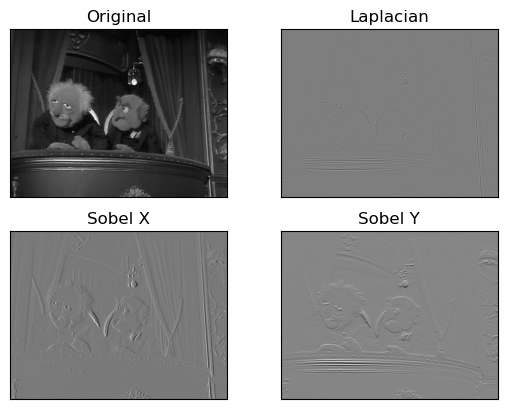

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img_path = '../data/frames/Muppets-03-04-03/frame_09302.jpg' 
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
assert img is not None, "file could not be read, check with os.path.exists()"
laplacian = cv.Laplacian(img,cv.CV_64F)
sobelx = cv.Sobel(img,cv.CV_64F,1,0,ksize=5)
sobely = cv.Sobel(img,cv.CV_64F,0,1,ksize=5)
plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

(<Axes: >, <matplotlib.image.AxesImage at 0x261d2c39c50>)

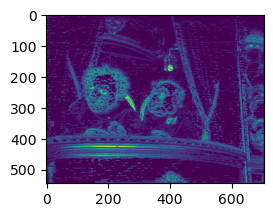

In [ ]:
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
img[abs(sobely) < 100] = 0.0
plt.subplot(2,2,4),plt.imshow(img)

15


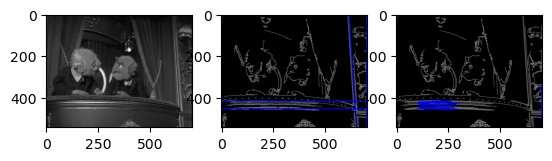

In [ ]:
import math
import cv2 as cv
img_path = '../data/frames/Muppets-03-04-03/frame_09404.jpg' 
src = cv.imread(img_path, cv.IMREAD_GRAYSCALE)    
dst = cv.Canny(src, 50, 200, None, 3)
    
# Copy edges to the images that will display the results in BGR
cdst = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)


lines = cv.HoughLinesWithAccumulator(dst, 1, np.pi / 180, 200, None, 0, 0)

pt1s = []
pt2s = []

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        pt1s.append(pt1)
        pt2s.append(pt2)
        cv.line(cdst, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
        if i == 3:
            break


# linesP = cv.HoughLinesP(dst, 0.5, np.pi / 10, 150, None, 50, 10)

print(len(linesP))

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)

plt.subplot(1,3,1)
plt.imshow(src)
plt.subplot(1,3,2)
plt.imshow(cdst)
plt.subplot(1,3,3)
plt.imshow(cdstP)

In [ ]:
import seaborn as sns
plt.hlines([p[0] for p in pt1s], [p[1] for p in pt1s], c='orange')
plt.hlines([p[0] for p in pt2s], [p[1] for p in pt2s], c='blue')

TypeError: hlines() missing 1 required positional argument: 'xmax'